In [1]:
import os
path = os.environ['MyNN']
os.sys.path.append(path)
import MyNN
import gym
import numpy as np
import collections

In [2]:
class ACAgent:
    def __init__(self, state_size, action_size, gamma=0.95, lam=0.98,
                 actor_lr=0.001, critic_lr=0.01, method='PPO_CEM', w=0.98):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma  # discount rate
        self.lam = lam # GAE disc rate
        self.actor_lr = actor_lr
        self.critic_lr = critic_lr
        self.method = method
        self.actor = self._build_model()
        self.critic = self._build_vf()
        self.actor.lr = actor_lr
        self.critic.lr = critic_lr
        self.scaler = MyNN.Scaler(state_size,w)
        self.replay_buff_x = None
        self.replay_buff_y = None

    def _build_model(self):
        model = MyNN.MyNN(self.state_size)
        model.add(self.state_size*5, 'Tanh')
        model.add(int(np.sqrt(self.action_size*self.state_size)*5), 'Tanh')
        model.add(self.action_size*5, 'Tanh')
        model.add(self.action_size, 'Softmax')
        model.compile(self.method, 'Adam')
        return model
    
    def _build_vf(self):
        model = MyNN.MyNN(self.state_size)
        model.add(self.state_size*5, 'Tanh')
        model.add(int(np.sqrt(self.action_size)*5), 'Tanh')
        model.add(5, 'Tanh')
        model.add(1, 'Linear')
        model.compile('MSE', 'Adam')
        return model
    
    def value_function_fit(self, x, y):
        if self.replay_buff_x is None:
            x_train, y_train = x, y
        else:
            x_train = np.hstack([x, self.replay_buff_x])
            y_train = np.hstack([y, self.replay_buff_y])
        self.replay_buff_x = x
        self.replay_buff_y = y
        self.critic.optimize(x_train, y_train, num_epochs=10, 
                             report_cost=False, batch_size=128, 
                            lr = self.critic_lr)

    def act(self, state):
        result = self.actor.forward(state, caching='no')
        return result

In [3]:
def running_reward(rewards, gamma):
    result = []
    run_rew = 0
    for reward in  rewards[0,:][::-1]:
        run_rew = run_rew*gamma + reward
        result.append(run_rew)
    return np.array(result[::-1]).reshape(1,-1)

def encode(actions, action_size):
    result = np.zeros((action_size, actions.shape[1]))
    result[actions, range(actions.shape[1])] = 1
    return result

def add_gae(traj, gamma, lam):
    rewards = traj['rewards'] #*(1-gamma)
    values = traj['values']
    traj['tds'] = rewards - values + np.append(traj['values'][0, 1:] * agent.gamma, 0).reshape(1,-1)
    gae = running_reward(traj['tds'], gamma*lam)
    return gae

In [4]:
def play_game(agent, render=False):
    state = env.reset().reshape((agent.state_size,1))
    unscaled_states = []
    states = []
    probs = []
    actions = []
    rewards = []
    done = False
    mean, var = agent.scaler.get()
    while not done:
        if render:
            env.render()
        unscaled_states.append(state)
        scaled_state = (state-mean)/var
        states.append(scaled_state)
        prob = agent.act(scaled_state)
        probs.append(prob)
        action = np.random.choice(range(agent.action_size), p=prob[:,0])
        actions.append(action)
        state, reward, done, _ = env.step(action)
        state = state.reshape((agent.state_size,1))
        rewards.append(reward)
        if done:
            break
    return {'unscaled': np.hstack(unscaled_states), 'states' : np.hstack(states),
            'probs': np.hstack(probs), 'actions': np.array(actions).reshape(1,-1),
            'rewards': np.array(rewards).reshape(1,-1)}

In [5]:
def play_n_games(agent, n=20):
    trajectories = []
    leng = 0
    for i in range(n):
        trajectory = play_game(agent)
        trajectories.append(trajectory)
        leng += trajectory['actions'].shape[1]
        if leng >= 20000:
            break
    return trajectories

In [6]:
def build_train_set(agent, trajectories):
    for traj in trajectories:
        traj['disc_sum_rew'] = running_reward(traj['rewards'], agent.gamma) #*(1-agent.gamma)
        traj['values'] = agent.critic.forward(traj['states'])
        traj['GAE'] = add_gae(traj, agent.gamma, agent.lam)
        traj['enc_actions'] = encode(traj['actions'], agent.action_size)
    X = np.hstack([t['states'] for t in trajectories])
    Y = np.hstack([t['probs'] for t in trajectories])
    actions = np.hstack([t['enc_actions'] for t in trajectories])
    disc_sum_rew = np.hstack([t['disc_sum_rew'] for t in trajectories])
    adv = np.hstack([t['GAE'] for t in trajectories])
    adv = (adv - adv.mean())/(adv.std() + 1e-6)
    return X, np.clip(Y, 0.001, 0.999), actions, adv, disc_sum_rew

In [7]:
env = gym.make('Acrobot-v1')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
base_lr = 0.001
agent = ACAgent(state_size, action_size, actor_lr=base_lr,
                critic_lr=base_lr*2, gamma=0.995, lam=0.98, method='PPO_CEM', w=1)
l=0
DKL_targ = 0.005
beta = 1
eta = 30

In [8]:
results = []
result = -500

In [9]:
%%time
for time in range(1, 1001):
    trajectories = play_n_games(agent, n=5)
    agent.scaler.update(np.hstack([t['unscaled'] for t in trajectories]))
    score = np.mean([(np.sum(t['rewards']), np.var(t['rewards'])) for t in trajectories], axis=0)
    X_batch, Y_batch, actions, adv, disc_sum_rew = build_train_set(agent, trajectories)
    for i in range(10):
        A = agent.actor.forward(X_batch)
        DKL = np.sum(Y_batch*np.log(np.divide(Y_batch,A)))/Y_batch.shape[1]
        if DKL > DKL_targ*4:
            print('Beta is too small')
            break
        agent.actor.cache['A0'] = X_batch
        agent.actor.backward(A, Y_batch, adv,actions=actions,
                             beta=beta, eta=eta, DKL=DKL, DKL_targ = DKL_targ)
        agent.actor.number_of_updates +=1
        agent.actor.update_parameters()
    if DKL > DKL_targ*2:
        beta = np.minimum(35, beta*1.5)
        print('Increasing beta')
        if beta > 30:
            agent.actor.lr = np.minimum(agent.actor.lr/1.1, base_lr*0.1)
            print('Decreasing learning rate')
    elif DKL < DKL_targ*0.5:
        beta = np.maximum(1/35, beta/1.5)
        print('Decreasing beta')
        if beta < 1/30:
            agent.actor.lr = np.maximum(agent.actor.lr*1.1, base_lr*10)
            print('Increasing learning rate')
    else:
        print('Beta remains the same')
    agent.value_function_fit(X_batch, disc_sum_rew)
    print(time, score[0], DKL, beta)
    result = result*0.98+score[0]*0.02
    results.append(result)
    if time % 50 == 0:
        agent.actor.save(path='actor_PPO_PONG.mnnd')
        agent.critic.save(path='critic_PPO_PONG.mnnd')
        agent.scaler.save(path='scaler_PPO_PONG.mnnd')

Beta remains the same
1 -500.0 0.003901227229019361 1
Decreasing beta
2 -500.0 0.0017463547645250297 0.6666666666666666
Decreasing beta
3 -446.8 0.0018694772017171708 0.4444444444444444
Beta remains the same
4 -481.8 0.004118264345571414 0.4444444444444444
Decreasing beta
5 -465.8 0.0022288125482260563 0.2962962962962963
Beta remains the same
6 -430.2 0.0077842537674462 0.2962962962962963
Beta remains the same
7 -440.2 0.009268151645201292 0.2962962962962963
Increasing beta
8 -425.2 0.01996141048475694 0.4444444444444444
Beta remains the same
9 -411.2 0.0026998430922324664 0.4444444444444444
Beta remains the same
10 -402.8 0.004347369882423751 0.4444444444444444
Beta remains the same
11 -380.2 0.003331521094605571 0.4444444444444444
Beta remains the same
12 -351.6 0.0075181237974528215 0.4444444444444444
Beta remains the same
13 -340.0 0.007522909578493126 0.4444444444444444
Beta remains the same
14 -345.8 0.0035694631494119396 0.4444444444444444
Beta remains the same
15 -334.0 0.00471

In [10]:
traj = play_game(agent, render=True)

In [11]:
import matplotlib.pyplot as plt

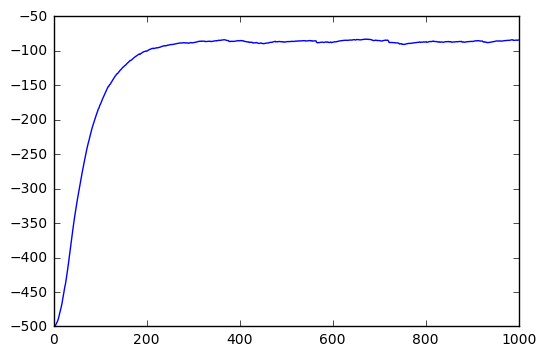

In [12]:
plt.plot(results)
plt.show()